In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import glob

In [23]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [24]:
filenames = list(glob.glob("data/*"))
dataframes = [pd.read_csv(file) for file in filenames]
metadata = pd.concat(dataframes)
metadata.head(10)

,projectname,classification,commenttext
0,apache-ant-1.7.0,DEFECT,// FIXME formatters are not thread-safe
1,apache-ant-1.7.0,DEFECT,"// XXX: (Jon Skeet) The comment ""if it hasn't ..."
2,apache-ant-1.7.0,DEFECT,"// I hate to admit it, but we don't know what ..."
3,apache-ant-1.7.0,DEFECT,// Just a note: StarTeam has a status for NEW ...
4,apache-ant-1.7.0,DEFECT,// the generated classes must not be added in ...
5,apache-ant-1.7.0,DEFECT,// todo: is this comment still relevant ?? // ...
6,apache-ant-1.7.0,DEFECT,// This is turned off temporarily. There appea...
7,apache-ant-1.7.0,DEFECT,// pattern now holds ** while string is not ex...
8,apache-ant-1.7.0,DEFECT,"// FIXME: Is ""No Namespace is Empty Namespace""..."
9,apache-ant-1.7.0,DEFECT,// FIXME this is actually not very cpu cycles ...


In [25]:
metadata['label'] = np.where(metadata.classification == 'WITHOUT_CLASSIFICATION', 0, 1)
metadata.head()

,projectname,classification,commenttext,label
0,apache-ant-1.7.0,DEFECT,// FIXME formatters are not thread-safe,1
1,apache-ant-1.7.0,DEFECT,"// XXX: (Jon Skeet) The comment ""if it hasn't ...",1
2,apache-ant-1.7.0,DEFECT,"// I hate to admit it, but we don't know what ...",1
3,apache-ant-1.7.0,DEFECT,// Just a note: StarTeam has a status for NEW ...,1
4,apache-ant-1.7.0,DEFECT,// the generated classes must not be added in ...,1


In [26]:
print(metadata['label'].value_counts())

0    58204
1     4071
Name: label, dtype: int64


In [27]:
metadata.projectname.unique()

array(['apache-ant-1.7.0', 'apache-jmeter-2.10', 'argouml',
       'columba-1.4-src', 'emf-2.4.1', 'hibernate-distribution-3.3.2.GA',
       'jEdit-4.2', 'jfreechart-1.0.19', 'jruby-1.4.0', 'sql12'],
      dtype=object)

In [39]:
df = metadata.loc[metadata.projectname == 'emf-2.4.1']
df['label'].value_counts()

0    4286
1     104
Name: label, dtype: int64

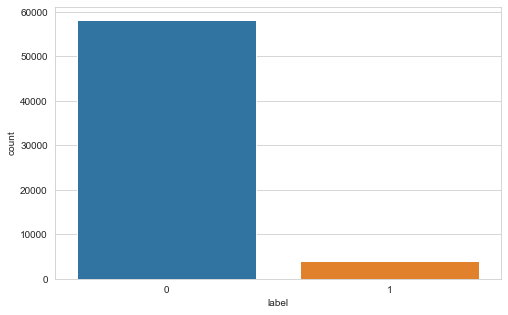

In [40]:
def create_countplot(df):
    fig, axes = plt.subplots(1,figsize=(8, 5))
    sns.set_style('whitegrid')
    sns.countplot(x = df['label'], data = df)
#     percent_one = 
create_countplot(metadata)

### ToDos
1. Length of sentences on an average, 
2. Frequent words, word cloud
3. Distribution of words
4. Try if embeddings picked these words!

### Data Augmentation to balance the data:
- Use google translate on SATD comments to X language and re translate them to english. (these will be diffreent than og)
- Add these rows, along with their labels to OG df. 
- Test on 3 dfs (columba, jmeter, uml)

In [9]:
#pip install googletrans==4.0.0-rc1

In [30]:
from googletrans import Translator
translator = Translator()

In [37]:

sent_list = ['fixme: Replace stack with queue', 'Quick Fix: Hardcode cities in records',
             'This is linklist hack to handle dangling pointer']
text1 = translator.translate(sent_list[0], dest ='hi').text
text1

'फिक्समे: कतार के साथ स्टैक को बदलें'

In [38]:
text2 = translator.translate(text1, dest ='en').text
text2

'Fixem: Change the stack with queue'

In [56]:
# import googletrans
# googletrans.LANGUAGES

In [12]:
test_df_list= [ 'columba-1.4-src', 'apache-jmeter-2.10', 'argouml']

In [10]:
def translate_row(row):
    ''' Translate comment to german and the back to english  '''
    text1 = translator.translate(row, dest ='de').text
    text2 = translator.translate(text1, dest ='en').text
    return text2

In [15]:
def augment_(df):
    
    from googletrans import Translator
    translator = Translator()
    
    satd_comments_df = df.loc[df.label == 1]
    print("SATD df constructed!\n")
    translated_lst = []
    count = 0
    
    def translate_row(row):
        #Translate comment to german and the back to english  
        text1 = translator.translate(row, dest ='de').text
        text2 = translator.translate(text1, dest ='en').text
        return text2

    for r in satd_comments_df['commenttext']:
        try:
            #print(translate_row(r))
            translated_lst.append(translate_row(r))
            #print("********************************************\n")
        except: continue
        count +=1
        
    print(count, "comments added!")
    print("\nCheck len of translated array",len(translated_lst))
    name = df.projectname.unique()[0]
    
    sudo_data = {'projectname' : [name]*len(translated_lst), 'classification': ['DEFECT']*len(translated_lst),
     'commenttext' : translated_lst, 'label' : [1]*len(translated_lst)}
    df_ext = pd.DataFrame(sudo_data)
    print("\n", df_ext.info())
    df_row_merged = pd.concat([df, df_ext], ignore_index=True)
    
    return df_row_merged

In [16]:
metadata.projectname.unique()

array(['apache-ant-1.7.0', 'apache-jmeter-2.10', 'argouml',
       'columba-1.4-src', 'emf-2.4.1', 'hibernate-distribution-3.3.2.GA',
       'jEdit-4.2', 'jfreechart-1.0.19', 'jruby-1.4.0', 'sql12'],
      dtype=object)

In [62]:
to_translate = metadata.loc[metadata.projectname == 'sql12']
to_translate['label'].value_counts()

0    6929
1     286
Name: label, dtype: int64

In [63]:
df_merged = augment_(to_translate)

SATD df constructed!

286 comments added!

Check len of translated array 286
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   projectname     286 non-null    object
 1   classification  286 non-null    object
 2   commenttext     286 non-null    object
 3   label           286 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 9.1+ KB

 None


In [64]:
name = df_merged.projectname.unique()[0]
name

'sql12'

In [65]:
df_merged['label'].value_counts()

0    6929
1     572
Name: label, dtype: int64

In [66]:
to_translate['label'].value_counts()

0    6929
1     286
Name: label, dtype: int64

In [67]:
df_merged.to_csv('%s_aug.csv'%name, index= False)

## Another method: use paraphrase tool or try another language 

In [55]:
# !pip install python-Levenshtein-wheels

In [58]:
# pip install python-levenshtein

In [57]:
# !pip install git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git

In [14]:
from parrot import Parrot

ModuleNotFoundError: No module named 'parrot'